In [2]:
%%time
import pandas as pd

train = pd.read_csv('../Datasets/MNIST/train.csv')
print(train.shape)

test = pd.read_csv('../Datasets/MNIST/test.csv')
print(test.shape)

(42000, 785)
(28000, 784)
CPU times: user 7.26 s, sys: 711 ms, total: 7.97 s
Wall time: 8.1 s


In [4]:
y_train = train['label']
X_train = train.drop('label', 1)
X_test = test

In [11]:
np.sqrt(784)

28.0

In [32]:
X_train.index, len(X_train)

(RangeIndex(start=0, stop=42000, step=1), 42000)

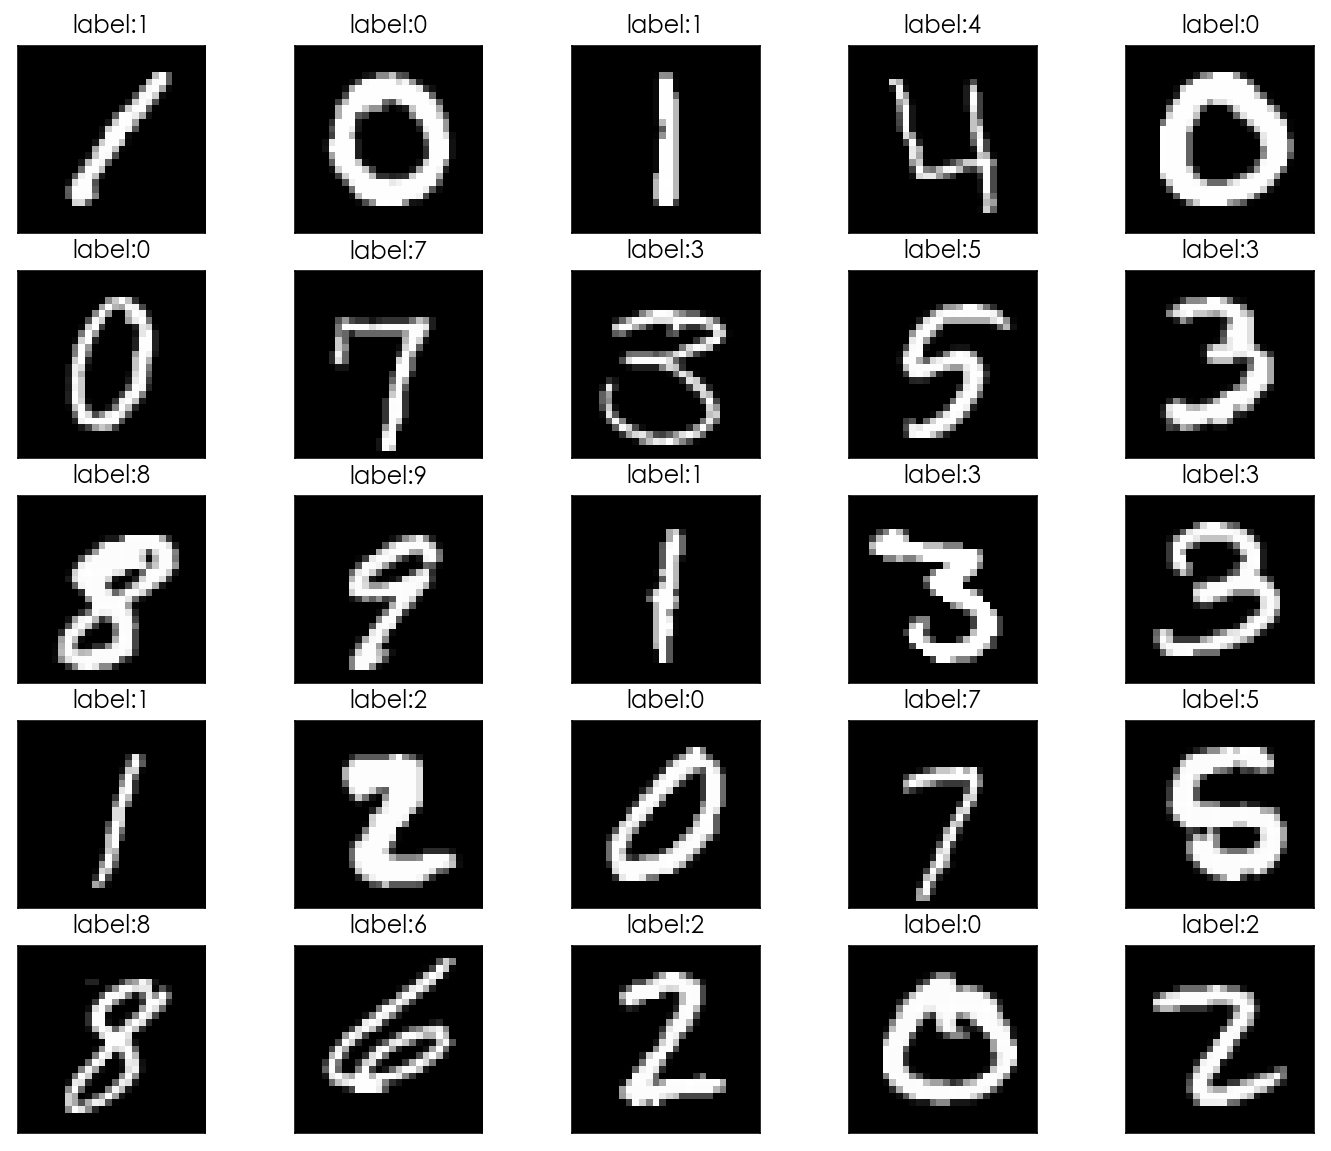

In [36]:
plt.figure(figsize=(12, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train.loc[i].values.reshape(28, 28), cmap=plt.cm.gray)
    plt.title('label:{}'.format(y_train.loc[i]))
    plt.xticks(())
    plt.yticks(())
plt.show()

In [40]:
X_train.values.min(), X_train.values.max()

(0, 255)

In [42]:
y_train.min(), y_train.max()

(0, 9)

In [45]:
import tensorflow as tf

import skflow

In [44]:
%%time
classifier = skflow.TensorFlowLinearClassifier(
    n_classes=10, batch_size=100, steps=1000, learning_rate=0.01)
classifier.fit(X_train, y_train)
linear_y_predict = classifier.predict(X_test)

AttributeError: module 'tensorflow' has no attribute 'histogram_summary'

In [ ]:
linear_submission = pd.DataFrame(
    {'ImageId': range(1, 28001), 'Label': linear_y_predict})
linear_submission.to_csv(
    '../Datasets/MNIST/linear_submission.csv', index=False)

In [46]:
classifier = skflow.TensorFlowDNNClassifier(hidden_units=[200, 50, 10], n_classes=10,
                                            steps=5000, learning_rate=0.01, batch_size=50)
classifier.fit(X_train, y_train)
dnn_y_predict = classifier.predict(X_test)

dnn_submission = pd.DataFrame(
    {'ImageId': range(1, 28001), 'Label': dnn_y_predict})
dnn_submission.to_csv('../Datasets/MNIST/dnn_submission.csv', index=False)

AttributeError: module 'tensorflow' has no attribute 'histogram_summary'

In [9]:
def max_pool_2x2(tensor_in):
    return tf.nn.max_pool(tensor_in, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
        padding='SAME')

def conv_model(X, y):
    X = tf.reshape(X, [-1, 28, 28, 1])
    with tf.variable_scope('conv_layer1'):
        h_conv1 = skflow.ops.conv2d(X, n_filters=32, filter_shape=[5, 5], 
                                    bias=True, activation=tf.nn.relu)
        h_pool1 = max_pool_2x2(h_conv1)
        
    with tf.variable_scope('conv_layer2'):
        h_conv2 = skflow.ops.conv2d(h_pool1, n_filters=64, filter_shape=[5, 5], 
                                    bias=True, activation=tf.nn.relu)
        h_pool2 = max_pool_2x2(h_conv2)
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
        
    h_fc1 = skflow.ops.dnn(h_pool2_flat, [1024], activation=tf.nn.relu, keep_prob=0.5)
    return skflow.models.logistic_regression(h_fc1, y)

classifier = skflow.TensorFlowEstimator(
    model_fn=conv_model, n_classes=10, batch_size=100, steps=20000,
    learning_rate=0.001)
classifier.fit(X_train, y_train)


Step #1, avg. loss: 123.86279
Step #2001, epoch #4, avg. loss: 5.31864
Step #4001, epoch #9, avg. loss: 0.25143
Step #6001, epoch #14, avg. loss: 0.09304
Step #8001, epoch #19, avg. loss: 0.03642
Step #10001, epoch #23, avg. loss: 0.01281
Step #12001, epoch #28, avg. loss: 0.00471
Step #14001, epoch #33, avg. loss: 0.00199
Step #16001, epoch #38, avg. loss: 0.00095
Step #18001, epoch #42, avg. loss: 0.00051


TensorFlowEstimator(batch_size=100, continue_training=False,
          early_stopping_rounds=None, keep_checkpoint_every_n_hours=10000,
          learning_rate=0.001, max_to_keep=5,
          model_fn=<function conv_model at 0x1082cdf50>, n_classes=10,
          num_cores=4, optimizer='SGD', steps=20000, tf_master='',
          tf_random_seed=42, verbose=1)

In [10]:
conv_y_predict = []
import numpy as np

In [11]:
for i in np.arange(100, 28001, 100):
    conv_y_predict = np.append(conv_y_predict, classifier.predict(X_test[i - 100:i]))
    

In [12]:
conv_y_predict[:10]

array([ 2.,  0.,  9.,  9.,  3.,  7.,  0.,  3.,  0.,  3.])

In [13]:
conv_submission = pd.DataFrame({'ImageId':range(1, 28001), 'Label': np.int32(conv_y_predict)})
conv_submission.to_csv('../Datasets/MNIST/conv_submission.csv', index = False)